In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from collections import Counter
import random
import matplotlib.pyplot as plt

# Purpose: Import libraries for data handling, numerical operations, text preprocessing,
# and plotting. Removed NLTK dependency.

In [2]:
# Load all datasets (subsample df5 to 10% to manage memory)
df1 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\sentiment_analysis.csv', encoding='latin1')
df2 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\test.csv', encoding='latin1')
df3 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\testdata.manual.2009.06.14.csv', encoding='latin1')
df4 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\train.csv', encoding='latin1')
df5 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\training.1600000.processed.noemoticon.csv', encoding='latin1').sample(frac=0.1, random_state=42)
df6 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\twitter_training.csv', encoding='latin1')
df7 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\twitter_validation.csv', encoding='latin1')

# Standardize column names and sentiment labels
df1 = df1[['text', 'sentiment']].copy()
df2 = df2[['text', 'sentiment']].copy()
df3.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df3['sentiment'] = df3['sentiment'].map({4: 'positive', 0: 'negative', 2: 'neutral'})
df3 = df3[['text', 'sentiment']].copy()
df4 = df4[['text', 'sentiment']].copy()
df5.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df5['sentiment'] = df5['sentiment'].map({4: 'positive', 0: 'negative', 2: 'neutral'})
df5 = df5[['text', 'sentiment']].copy()
df6.columns = ['id', 'entity', 'sentiment', 'text']
df6['sentiment'] = df6['sentiment'].map({'Positive': 'positive', 'Negative': 'negative', 'Neutral': 'neutral', 'Irrelevant': 'neutral'})
df6 = df6[['text', 'sentiment']].copy()
df7.columns = ['id', 'entity', 'sentiment', 'text']
df7['sentiment'] = df7['sentiment'].map({'Positive': 'positive', 'Negative': 'negative', 'Neutral': 'neutral', 'Irrelevant': 'neutral'})
df7 = df7[['text', 'sentiment']].copy()

# Combine all datasets
combined_df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

# Remove rows with missing text or sentiment
combined_df.dropna(subset=['text', 'sentiment'], inplace=True)

# Convert text to string
combined_df['text'] = combined_df['text'].astype(str)

# Purpose: Load datasets, subsample df5, standardize columns and labels, and combine.

In [3]:
# Define stop words manually
stop_words = {'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he', 
              'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'were', 'will', 
              'with', 'i', 'you', 'your', 'they', 'their', 'this', 'but', 'have', 'not', 'or'}

# Clean text: lowercase, remove URLs, special characters, emojis, split into words, remove stop words
cleaned_texts = []
for text in combined_df['text']:
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove emojis
    tokens = text.split()  # Simple tokenization by splitting on whitespace
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    cleaned_texts.append(' '.join(tokens))

# Add cleaned text to DataFrame
combined_df['cleaned_text'] = cleaned_texts

# Filter valid sentiments
valid_sentiments = ['positive', 'negative', 'neutral']
combined_df = combined_df[combined_df['sentiment'].isin(valid_sentiments)].copy()

# Remove empty cleaned_text
combined_df = combined_df[combined_df['cleaned_text'].str.strip() != ''].copy()

# Purpose: Clean text data using basic Python, filter invalid sentiments, and remove empty texts.
# Replaced NLTK tokenization with text.split(), used manual stop word list, skipped lemmatization.

In [4]:
# Build vocabulary from cleaned texts (top 5,000 words)
word_counts = Counter()
for text in combined_df['cleaned_text']:
    words = text.split()
    word_counts.update(words)

# Select top 5,000 words
max_vocab_size = 5000
vocab = [word for word, _ in word_counts.most_common(max_vocab_size)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Purpose: Create a vocabulary of the top 5,000 words.

In [5]:
# Compute TF-IDF features
n_docs = len(combined_df)
vocab_size = len(word_to_idx)
tf_matrix = np.zeros((n_docs, vocab_size))

# Compute term frequency
for doc_idx, text in enumerate(combined_df['cleaned_text']):
    words = text.split()
    word_counts = Counter(words)
    for word, count in word_counts.items():
        if word in word_to_idx:
            tf_matrix[doc_idx, word_to_idx[word]] = count / len(words)

# Compute inverse document frequency
doc_freq = np.sum(tf_matrix > 0, axis=0)
idf = np.log(n_docs / (1 + doc_freq))

# Compute TF-IDF
tfidf_matrix = tf_matrix * idf

# Normalize TF-IDF vectors
norms = np.sqrt(np.sum(tfidf_matrix ** 2, axis=1, keepdims=True))
tfidf_matrix = tfidf_matrix / (norms + 1e-10)

# Convert to dense array
tfidf_matrix = tfidf_matrix.astype(np.float64)

# Purpose: Convert text to TF-IDF features, normalize, and ensure dense array.

In [6]:
# Encode sentiment labels to one-hot vectors
label_to_idx = {'positive': 0, 'negative': 1, 'neutral': 2}
n_samples = len(combined_df)
n_classes = len(label_to_idx)
one_hot_labels = np.zeros((n_samples, n_classes))
for idx, sentiment in enumerate(combined_df['sentiment']):
    one_hot_labels[idx, label_to_idx[sentiment]] = 1

# Purpose: Convert sentiment labels to one-hot vectors.

In [7]:
# Split data into training (80%) and testing (20%) sets
np.random.seed(42)
indices = np.arange(tfidf_matrix.shape[0])
np.random.shuffle(indices)
n_test = int(0.2 * tfidf_matrix.shape[0])
test_indices = indices[:n_test]
train_indices = indices[n_test:]

X_train = tfidf_matrix[train_indices]
X_test = tfidf_matrix[test_indices]
y_train = one_hot_labels[train_indices]
y_test = one_hot_labels[test_indices]

# Purpose: Split data into training and testing sets.

In [8]:
# Logistic regression parameters
input_size = X_train.shape[1]
output_size = y_train.shape[1]

# Initialize weights and bias
W = np.random.randn(input_size, output_size) * 0.01
b = np.zeros((1, output_size))

# Purpose: Initialize weights and bias for logistic regression.

In [9]:
# Softmax activation
softmax = lambda x: np.exp(x - np.max(x, axis=1, keepdims=True)) / np.sum(np.exp(x - np.max(x, axis=1, keepdims=True)), axis=1, keepdims=True)

# Cross-entropy loss
cross_entropy_loss = lambda y_pred, y_true: -np.sum(y_true * np.log(y_pred + 1e-10)) / y_true.shape[0]

# Purpose: Define softmax and cross-entropy loss for logistic regression.

In [10]:
# Training parameters
epochs = 50
batch_size = 64
learning_rate = 0.01
n_batches = X_train.shape[0] // batch_size

train_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    # Shuffle indices
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    
    epoch_loss = 0
    for i in range(0, X_train.shape[0], batch_size):
        batch_indices = indices[i:i+batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        
        # Forward pass
        z = np.dot(X_batch, W) + b
        y_pred = softmax(z)
        
        # Compute loss
        loss = cross_entropy_loss(y_pred, y_batch)
        epoch_loss += loss
        
        # Backward pass
        m = X_batch.shape[0]
        delta = y_pred - y_batch
        dW = np.dot(X_batch.T, delta) / m
        db = np.sum(delta, axis=0, keepdims=True) / m
        
        # Update weights and bias
        W -= learning_rate * dW
        b -= learning_rate * db
    
    # Average loss
    epoch_loss /= n_batches
    
    # Compute training accuracy
    z_train = np.dot(X_train, W) + b
    y_train_pred = softmax(z_train)
    train_accuracy = np.mean(np.argmax(y_train_pred, axis=1) == np.argmax(y_train, axis=1))
    
    # Compute testing accuracy
    z_test = np.dot(X_test, W) + b
    y_test_pred = softmax(z_test)
    test_accuracy = np.mean(np.argmax(y_test_pred, axis=1) == np.argmax(y_test, axis=1))
    
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Purpose: Train logistic regression using mini-batch gradient descent.

Epoch 1/50, Loss: 1.0158, Train Accuracy: 0.5284, Test Accuracy: 0.5318
Epoch 2/50, Loss: 1.0043, Train Accuracy: 0.5284, Test Accuracy: 0.5318
Epoch 3/50, Loss: 0.9974, Train Accuracy: 0.5284, Test Accuracy: 0.5318
Epoch 4/50, Loss: 0.9909, Train Accuracy: 0.5284, Test Accuracy: 0.5319
Epoch 5/50, Loss: 0.9846, Train Accuracy: 0.5290, Test Accuracy: 0.5324
Epoch 6/50, Loss: 0.9787, Train Accuracy: 0.5298, Test Accuracy: 0.5332
Epoch 7/50, Loss: 0.9729, Train Accuracy: 0.5310, Test Accuracy: 0.5344
Epoch 8/50, Loss: 0.9674, Train Accuracy: 0.5332, Test Accuracy: 0.5368
Epoch 9/50, Loss: 0.9622, Train Accuracy: 0.5346, Test Accuracy: 0.5380
Epoch 10/50, Loss: 0.9572, Train Accuracy: 0.5366, Test Accuracy: 0.5398
Epoch 11/50, Loss: 0.9525, Train Accuracy: 0.5392, Test Accuracy: 0.5427
Epoch 12/50, Loss: 0.9478, Train Accuracy: 0.5432, Test Accuracy: 0.5463
Epoch 13/50, Loss: 0.9434, Train Accuracy: 0.5454, Test Accuracy: 0.5485
Epoch 14/50, Loss: 0.9392, Train Accuracy: 0.5487, Test Accu

In [11]:
# Forward pass on test set
z_test = np.dot(X_test, W) + b
y_pred = softmax(z_test)

# Compute evaluation metrics
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)

# Precision, Recall, F1 per class
precision = np.zeros(n_classes)
recall = np.zeros(n_classes)
f1 = np.zeros(n_classes)
for c in range(n_classes):
    true_positives = np.sum((y_pred_labels == c) & (y_true_labels == c))
    predicted_positives = np.sum(y_pred_labels == c)
    actual_positives = np.sum(y_true_labels == c)
    precision[c] = true_positives / (predicted_positives + 1e-10)
    recall[c] = true_positives / (actual_positives + 1e-10)
    f1[c] = 2 * (precision[c] * recall[c]) / (precision[c] + recall[c] + 1e-10)

print(f"\nFinal Test Accuracy: {accuracy:.4f}")
print("Precision per class (positive, negative, neutral):", precision)
print("Recall per class (positive, negative, neutral):", recall)
print("F1-score per class (positive, negative, neutral):", f1)

# Purpose: Evaluate logistic regression on the test set.


Final Test Accuracy: 0.6265
Precision per class (positive, negative, neutral): [0.69487179 0.61253131 0.70464964]
Recall per class (positive, negative, neutral): [0.34372169 0.96066613 0.12397742]
F1-score per class (positive, negative, neutral): [0.45993454 0.74807913 0.21085636]


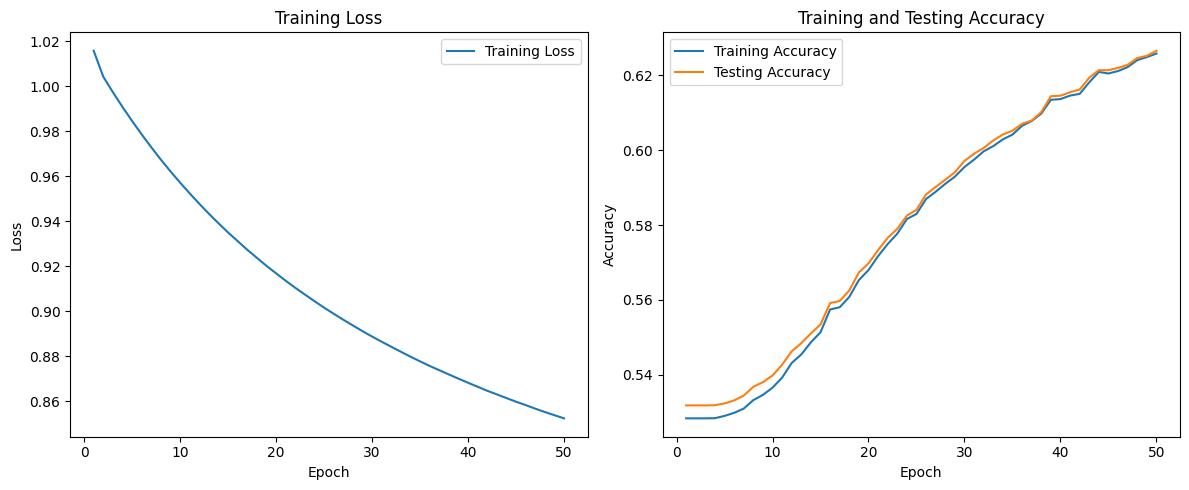

In [12]:
# Plot training loss and accuracies
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Purpose: Visualize training loss and accuracies.

In [13]:
# Define stop words
stop_words = {'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he', 
              'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'were', 'will', 
              'with', 'i', 'you', 'your', 'they', 'their', 'this', 'but', 'have', 'not', 'or'}

# Example input text
custom_text = "I love this movie, it's absolutely fantastic!"

# Preprocess input text
text = custom_text.lower()
text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
text = re.sub(r'[^a-z\s]', '', text)
text = re.sub(r'[^\x00-\x7F]+', '', text)
tokens = text.split()
tokens = [word for word in tokens if word not in stop_words]
cleaned_text = ' '.join(tokens)

# Convert to TF-IDF features
tf_vector = np.zeros((1, vocab_size))
if cleaned_text.strip():
    words = cleaned_text.split()
    word_counts = Counter(words)
    for word, count in word_counts.items():
        if word in word_to_idx:
            tf_vector[0, word_to_idx[word]] = count / len(words)

# Apply IDF and normalize
tfidf_vector = tf_vector * idf
norm = np.sqrt(np.sum(tfidf_vector ** 2))
if norm > 0:
    tfidf_vector = tfidf_vector / norm

# Forward pass
z = np.dot(tfidf_vector, W) + b
y_pred = softmax(z)

# Get predicted sentiment
predicted_idx = np.argmax(y_pred, axis=1)[0]
idx_to_label = {0: 'positive', 1: 'negative', 2: 'neutral'}
predicted_sentiment = idx_to_label[predicted_idx]

print(f"\nInput Text: {custom_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Prediction Probabilities (positive, negative, neutral): {y_pred[0]}")

# Purpose: Predict sentiment on custom text using logistic regression, without NLTK.


Input Text: I love this movie, it's absolutely fantastic!
Predicted Sentiment: positive
Prediction Probabilities (positive, negative, neutral): [0.62917056 0.18713325 0.18369619]


In [14]:
import pickle

# Dictionary to store model and preprocessing components
model_data = {
    'W': W,
    'b': b,
    'word_to_idx': word_to_idx,
    'idf': idf,
    'vocab_size': vocab_size,
    'label_to_idx': label_to_idx
}

# Save to pickle file
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model and preprocessing components saved to 'sentiment_model.pkl'")

# Purpose: Save the trained logistic regression model (weights and bias) and
# preprocessing components (vocabulary, IDF, label mappings) to a pickle file
# for future use in predictions.

Model and preprocessing components saved to 'sentiment_model.pkl'
